Učitavanje potrebnih biblioteka

In [45]:
from skimage import io
import skimage
import skimage.transform
from skimage import feature

from scipy import ndimage
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd

# Prvi zadatak

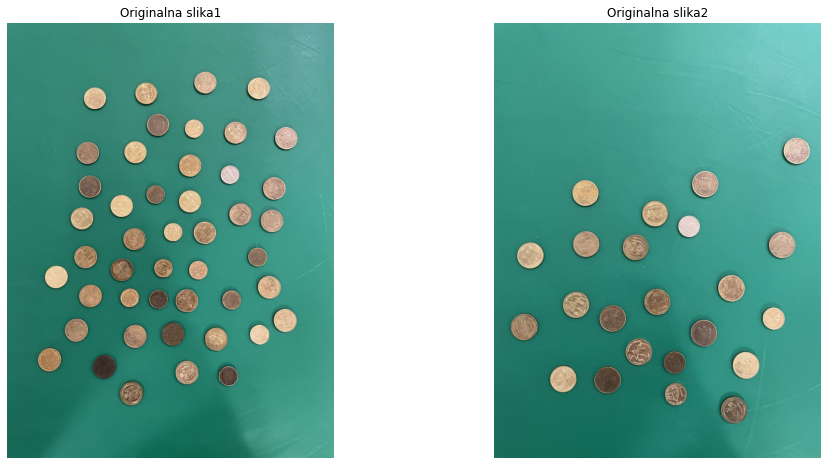

In [48]:
# ucitavanje slike
coin_image1 = io.imread('../sekvence/coins/coins1.jpg')
coin_image2 = io.imread('../sekvence/coins/coins2.jpg')
# prikaz slike
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(coin_image1, 'gray') 
plt.title('Originalna slika1')
plt.axis('off');
plt.subplot(1,2,2)
plt.imshow(coin_image2, 'gray')
plt.title('Originalna slika2')
plt.axis('off');

### 1) Kreiranje binarne maske

Kao prvi korak u obradi, predloženo je zamućivanje slike Medijan filtrom - kako bi se dobila ujednačenija slika sa manje naglih prelaza. 

In [49]:
median_coin_image1 = cv2.medianBlur(coin_image1, 31, 30)
median_coin_image2 = cv2.medianBlur(coin_image2, 31, 30)

U daljoj obradi, slika je prebačena u drugi prostor boja - iz rgb-a u hsv, kako bi se jasnije uočila razlika između nijansi novčića i pozadine. Poznato je da je u hsv formatu dosta lakše detektovati žutu boju (a novčići delom sadrže nijanse iste). Nadalje će se segmentacija novčića vršiti posmatranjem hue kanala.

In [50]:
hsv_coin_image1 = skimage.color.rgb2hsv(median_coin_image1)
hsv_coin_image2 = skimage.color.rgb2hsv(median_coin_image2)

In [51]:
hue_coin_image1 = hsv_coin_image1[:, :, 0]
hue_coin_image2 = hsv_coin_image2[:, :, 0]

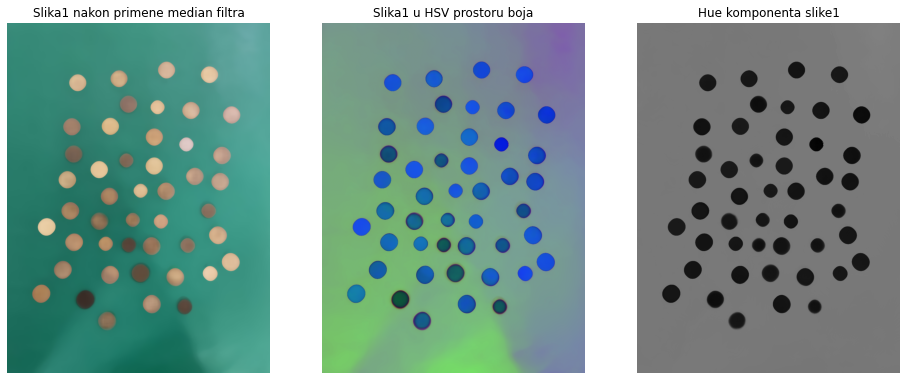

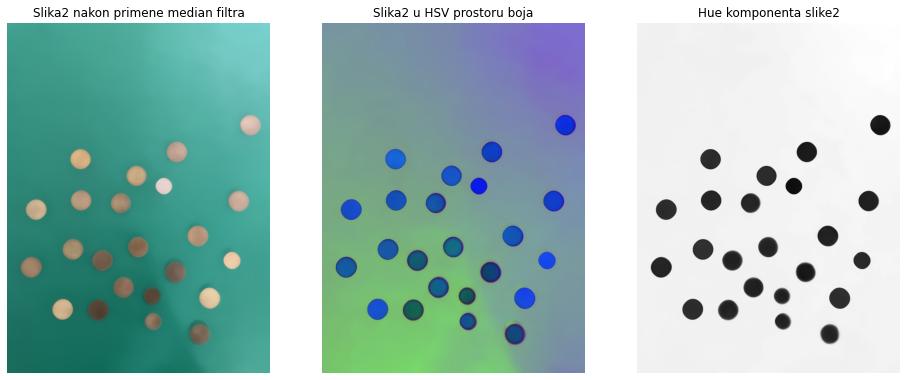

In [52]:
# prikaz slike1 nakon datih koraka
plt.figure(figsize=(16,8))
plt.subplot(1, 3, 1)
plt.imshow(median_coin_image1, 'gray')
plt.title('Slika1 nakon primene median filtra')
plt.axis('off');
plt.subplot(1, 3, 2)
plt.imshow(hsv_coin_image1, 'gray')
plt.title('Slika1 u HSV prostoru boja')
plt.axis('off');
plt.subplot(1, 3, 3)
plt.imshow(hue_coin_image1, 'gray')
plt.title('Hue komponenta slike1')
plt.axis('off');

# prikaz slike2 nakon datih koraka  
plt.figure(figsize=(16,8))
plt.subplot(1, 3, 1)
plt.imshow(median_coin_image2, 'gray')
plt.title('Slika2 nakon primene median filtra')
plt.axis('off');
plt.subplot(1, 3, 2)
plt.imshow(hsv_coin_image2, 'gray')
plt.title('Slika2 u HSV prostoru boja')
plt.axis('off');
plt.subplot(1, 3, 3)
plt.imshow(hue_coin_image2, 'gray')
plt.title('Hue komponenta slike2')
plt.axis('off');

Vrednost granice za binarizaciju određuje se usrednjavanjem slike i množenjem iste sa koeficijentima 0.9 i 1.2, da ukoliko se desi prevelika koncentracija tamnih ili belih novčića ne bi došlo do loše detekcije.

In [53]:
# za sliku1
background1 = hue_coin_image1.mean()             # usrednjavanje slike radi određivanja pozadine 

new_image11 = hue_coin_image1 > background1*0.9  # pozadine na slici  
new_image11 = np.invert(new_image11)             # inverzija vrednosti piksela slike (radi detekcije novcica)
# u nekim slucajevima postoje i beli i crni novcici, pa se samo beli novcici detektuju pomocu ove maske
new_image21 = hue_coin_image1 > background1*1.2   
if new_image21[0,0] == 1:                        # u zavisnosti od toga da li postoji beli novcic pozadina je 
                                                 # nekada bela nekad crna, pa je potrebno u odgovarajucem 
    new_image21 = np.invert(new_image21)         # slucaju invertovati sliku

new_image1 = new_image11 + new_image21           # formiranje maske

In [54]:
# za sliku2
background2 = hue_coin_image2.mean()             # usrednjavanje slike radi određivanja pozadine

new_image12 = hue_coin_image2 > background2*0.9  # pozadine na slici
new_image12 = np.invert(new_image12)             # inverzija vrednosti piksela slike (radi detekcije novcica)
# u nekim slucajevima postoje i beli i crni novcici, pa se samo beli novcici detektuju pomocu ove maske
new_image22 = hue_coin_image2 > background2*1.2
if new_image22[0,0] == 1:                        # u zavisnosti od toga da li postoji beli novcic pozadina je 
                                                 # nekada bela nekad crna, pa je potrebno u odgovarajucem 
    new_image22 = np.invert(new_image22)         # slucaju invertovati sliku

new_image2 = new_image12 + new_image22           # formiranje maske

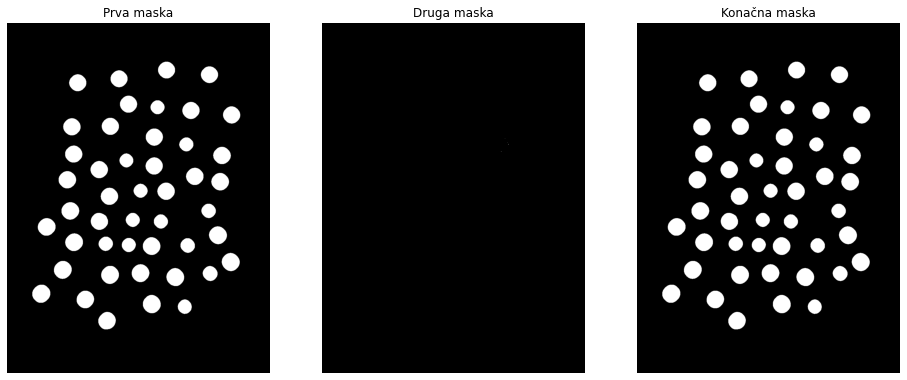

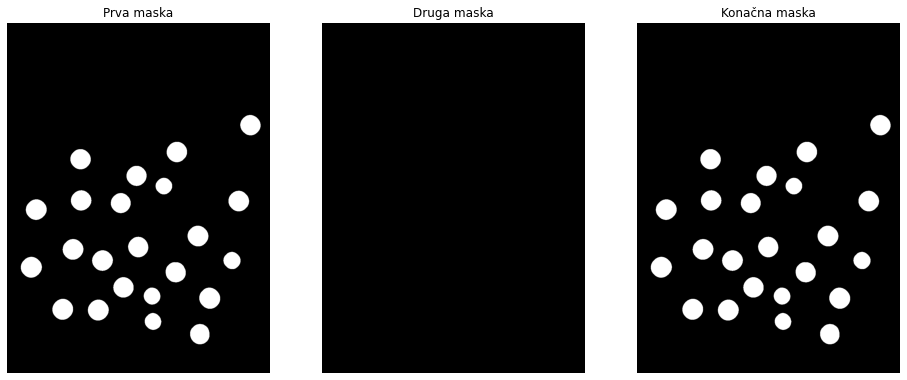

In [55]:
plt.figure(figsize=(16,8))
plt.subplot(1, 3, 1)
plt.imshow(new_image11, 'gray')
plt.title('Prva maska')
plt.axis('off');
plt.subplot(1, 3, 2)
plt.imshow(new_image21, 'gray')
plt.title('Druga maska')
plt.axis('off');
plt.subplot(1, 3, 3)
plt.imshow(new_image1, 'gray')
plt.title('Konačna maska')
plt.axis('off');

plt.figure(figsize=(16,8))
plt.subplot(1, 3, 1)
plt.imshow(new_image12, 'gray')
plt.title('Prva maska')
plt.axis('off');
plt.subplot(1, 3, 2)
plt.imshow(new_image22, 'gray')
plt.title('Druga maska')
plt.axis('off');
plt.subplot(1, 3, 3)
plt.imshow(new_image2, 'gray')
plt.title('Konačna maska')
plt.axis('off');

Nakon formiranja inicijalne maske, primenjene su operacije dilatacije i erozije da bi se uklonle sitnje smetnje koje su detektovane, a ne prestavljaju deo novčića.

In [56]:
kernel = np.ones((3,3),np.uint8)        # formiranje kernela za eroziju i dilataciju

# erozija slike
new_image1 = cv2.erode(new_image1.astype(np.uint8),kernel,iterations = 1)
new_image2 = cv2.erode(new_image2.astype(np.uint8),kernel,iterations = 1)
# dilatacija slike
new_image1 = cv2.dilate(new_image1.astype(np.uint8),kernel,iterations = 1)
new_image2 = cv2.dilate(new_image2.astype(np.uint8),kernel,iterations = 1)

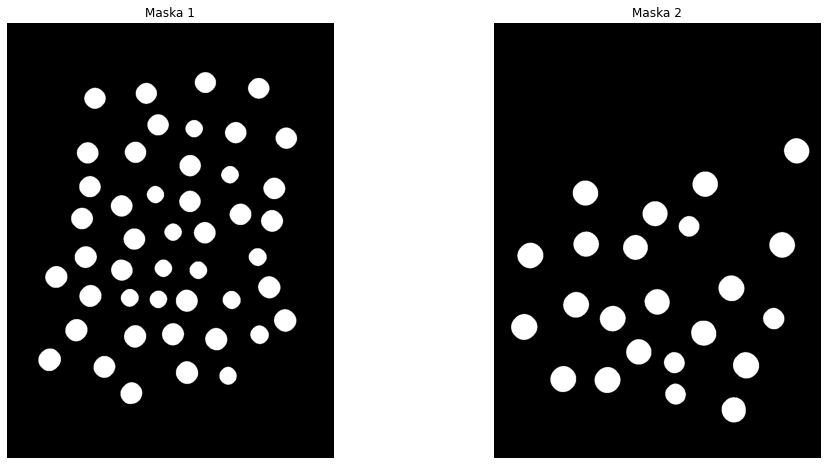

In [57]:
# prikaz finalne maske
plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.imshow(new_image1, 'gray')
plt.title('Maska 1')
plt.axis('off');
plt.subplot(1, 2, 2)
plt.imshow(new_image2, 'gray')
plt.title('Maska 2')
plt.axis('off');

Grupisanje svih koraka u traženu funkciju

In [58]:
def coin_mask(img_in):
    """img_in: ulazna slika
       new_image: izlazna maska za detekciju novčića"""
    
    img_in = cv2.medianBlur(img_in, 31, 30)
    img_hsv = skimage.color.rgb2hsv(img_in)
    
    img_hue = img_hsv[:,:,0]

    background = img_hue.mean()
    new_image1 = img_hue > background*0.9
    new_image1 = np.invert(new_image1)
    new_image2 = img_hue > background*1.2
    if new_image2[0,0] == 1:
        new_image2 = np.invert(new_image2)
    new_image = new_image1 + new_image2

    kernel = np.ones((3,3),np.uint8)
    new_image = cv2.erode(new_image.astype(np.uint8),kernel,iterations = 1)
    new_image = cv2.dilate(new_image.astype(np.uint8),kernel,iterations = 1)

    return new_image

### 2) Algoritam određivanja povezanih regiona

Za labeliranje zasebnih regiona slike, potrebno je koristiti algoritam određivanja povezanih regiona, posmatranjem 8 susedstva. Iteracijom kroz masku slike, za svaki piksel koji je detektovan kao deo nekog objekta proveravaju se labele susednih (prethodno proverenih piksela - gore, levo, gore-levo, gore-desno) i ukoliko neki od datih piksela već sadrži labelu, vrednost trebutnog postaje ta ista. Kada se desi da više piksela u susedstvu ima različite labele, one se grupišu u istu.  
           
Implementirana je funkcija koja obrađuje sliku na prethodno opisan način i kao izlaz vraća novo-labeliranu listu, kao i listu svih labela.

In [59]:
def bw_label(img_in):
    """ odredjivanje povezanih regiona na slici - 8 susedstvo
    pikseli pozadine imaju vrednost 0, pikseli objekata imaju vrednost labele objekta
    funkcija vraca sliku sa obelezenim regionima
    img_in: ulazna slika
    labeled_picture: izlazna slika sa obelezenim regionima"""

    labeled_picture = np.zeros(img_in.shape, dtype=np.int32)        # inicijalizacija slike za obeležavanje regiona
    label = 1                                                       # inicijalizacija labele    
    for i in range(1, img_in.shape[0]-1):
        for j in range(1, img_in.shape[1]-1):                       # prolazak kroz matricu slike
            if img_in[i,j] == 1:                                    # ako je piksel deo nekog objekta
                if img_in[i-1,j] != 0:                              # ako piksel iznad trenutnog ima labelu
                    labeled_picture[i,j] = labeled_picture[i-1,j]   # njeno preuzimanje

                    # provera da li je potrebno spajanje regiona
                    if (labeled_picture[i-1,j] != labeled_picture[i,j-1] and labeled_picture[i,j-1] != 0):
                        labeled_picture[labeled_picture == labeled_picture[i,j-1]] = labeled_picture[i-1,j]
                    if (labeled_picture[i-1,j] != labeled_picture[i-1,j-1] and labeled_picture[i-1,j-1] != 0):
                        labeled_picture[labeled_picture == labeled_picture[i-1,j-1]] = labeled_picture[i-1,j]
                    if (labeled_picture[i-1,j] != labeled_picture[i-1,j+1] and labeled_picture[i-1,j+1] != 0):
                        labeled_picture[labeled_picture == labeled_picture[i-1,j+1]] = labeled_picture[i-1,j]

                elif img_in[i,j-1] != 0:                            # ako piksel levo od trenutnog ima labelu
                    labeled_picture[i,j] = labeled_picture[i,j-1]   # njeno preuzimanje

                    # provera da li je potrebno spajanje regiona
                    if (labeled_picture[i,j-1] != labeled_picture[i-1,j-1] and labeled_picture[i-1,j-1] != 0):
                        labeled_picture[labeled_picture == labeled_picture[i-1,j-1]] = labeled_picture[i,j-1]
                    if (labeled_picture[i,j-1] != labeled_picture[i-1,j+1] and labeled_picture[i-1,j+1] != 0):
                        labeled_picture[labeled_picture == labeled_picture[i-1,j+1]] = labeled_picture[i,j-1]

                elif img_in[i-1,j-1] != 0:                          # ako piksel gore-levo od trenutnog ima labelu
                    labeled_picture[i,j] = labeled_picture[i-1,j-1] # njeno preuzimanje

                    # provera da li je potrebno spajanje regiona
                    if (labeled_picture[i-1,j-1] != labeled_picture[i-1,j+1] and labeled_picture[i-1,j+1] != 0):
                        labeled_picture[labeled_picture == labeled_picture[i-1,j+1]] = labeled_picture[i-1,j-1]
                elif img_in[i-1,j+1] != 0:                          # ako piksel gore-desno od trenutnog ima labelu
                    labeled_picture[i,j] = labeled_picture[i-1,j+1] # njeno preuzimanje

                else:                                               # ako nijedan od susednih piksela nema labelu
                    labeled_picture[i,j] = label                    # dodela nove labele
                    label += 1                                      # nova labela za novi objekat

    labeled_picture = labeled_picture/label     # normalizacija slike sa obeleženim regionima
    labels = set(labeled_picture.flatten())     # izdvajanje labela regiona
    labels = sorted(list(labels))[1:]           # izostavnjanje 0 - pozadina

    # slika sa obeleženim regionima i labele regiona
    return labeled_picture, labels

In [60]:
# određivanje maske i obeležavanje regiona
maska1 = coin_mask(coin_image1)
labeled_pic1, labels1 = bw_label(maska1)

maska2 = coin_mask(coin_image2)
labeled_pic2, labels2 = bw_label(maska2)

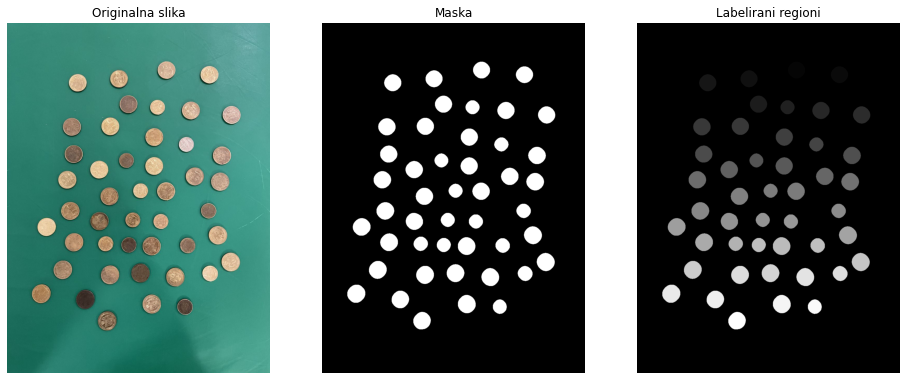

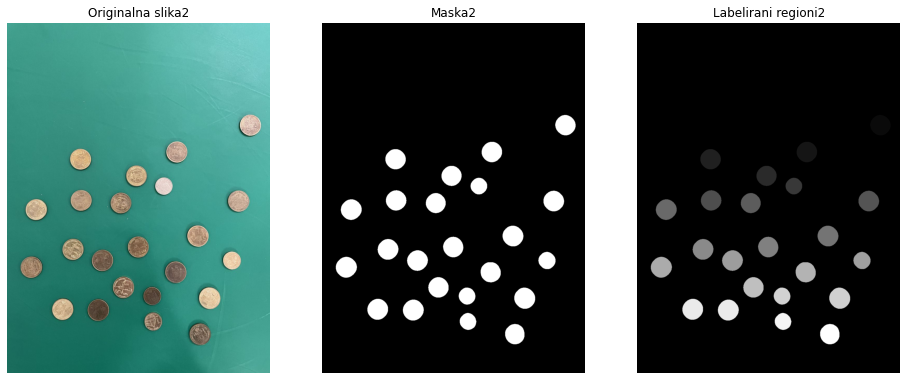

In [620]:
# prikaz slika
plt.figure(figsize=(16,8))
plt.subplot(1, 3, 1)
plt.imshow(coin_image1, 'gray')
plt.title('Originalna slika')
plt.axis('off');
plt.subplot(1, 3, 2)
plt.imshow(maska1, 'gray')
plt.title('Maska')
plt.axis('off');
plt.subplot(1, 3, 3)
plt.imshow(labeled_pic1, 'gray')
plt.title('Labelirani regioni')
plt.axis('off');

plt.figure(figsize=(16,8))
plt.subplot(1, 3, 1)
plt.imshow(coin_image2, 'gray')
plt.title('Originalna slika2')
plt.axis('off');
plt.subplot(1, 3, 2)
plt.imshow(maska2, 'gray')
plt.title('Maska2')
plt.axis('off');
plt.subplot(1, 3, 3)
plt.imshow(labeled_pic2, 'gray')
plt.title('Labelirani regioni2')
plt.axis('off');

Broj različitih ojekata na slici predstavlja samu dužinu liste labela.

In [61]:
number_of_coins1 = len(labels1)
number_of_coins2 = len(labels2)
print(number_of_coins1, number_of_coins2)

46 23


Definisanje liste tačnog broja novčića na svakoj slici.

In [62]:
number_of_coins_per_pic = [46, 23, 17, 11, 34, 32, 46, 46, 35]

Upoređivanje tačnog broja novčića i broja detektovanih jedinstvenih obejekata (novčića) na svakoj slici.

In [27]:
number_of_coins_detected = []           # inicijalizacija liste za broj detektovanih novčića
for i in range(1,10):                   # prolazak kroz sve slike
    coin_image = io.imread('../sekvence/coins/coins'+str(i)+'.jpg')   # učitavanje slike
    maska = coin_mask(coin_image)                               # određivanje maske
    labeled_pic, labels = bw_label(maska)                       # određivanje obeleženih regiona
    number_of_coins_detected.append(len(labels))                # dodavanje broja detektovanih novčića u listu

Tabelarni prikaz tačnog i detektovanog broja novčića.

In [30]:
df = pd.DataFrame({'Tacan broj novcica': number_of_coins_per_pic, 'Detektovani broj novcica': number_of_coins_detected})
df

Tacan broj novcica  Detektovani broj novcica
0                  46                        46
1                  23                        23
2                  17                        17
3                  11                        11
4                  34                        34
5                  32                        32
6                  46                        46
7                  46                        46
8                  35                        35

### 3) Klasifikacija novčića na one od 1 din. i 5 din.

Površina svakog novčića određena je sumiranjem svih piksela slike koji imaju vrednost date labele. Srednja vrednost veličine novčića određena je sumiranjem svih piksela koji pripadaju nekom objektu i deljenjem sa brojem objekata na slici. Data vrednost korišćena je kao prag prilikom klasifikacije.

In [69]:
def coin_classification(image_in):

    # predobrada slike
    maska = coin_mask(image_in)
    labeled_pic, labels = bw_label(maska)

    broj_novcica = [0, 0] # [0] - 1 din, [1] - 5 dinara

    # odredjivanje prosečne veličine novčića
    number_of_coins = len(labels)
    num_of_pixels_coins = sum(maska.flatten())
    average_coin_size = num_of_pixels_coins/number_of_coins * 0.9

    coin_centers = [[],[]]   # centri 1 i 5

    # klasifikacija novčića
    for coin in labels:
        coin_size = sum(labeled_pic.flatten() == coin)

        # za brze izvršavanje koda, zakomentarisati odredjivanje centara novčića (dva naredna reda) - ako se ne prikazuju labele na objektima
        coin_pixels = np.where(labeled_pic == coin)
        coin_center = (coin_pixels[0].mean().astype(int), coin_pixels[1].mean().astype(int))

        if coin_size < average_coin_size:
            broj_novcica[0] += 1
            # za brze izvršavanje koda, zakomentarisati dodavanje centara novčića (naredni red) - ako se ne prikazuju labele na objektima
            coin_centers[0].append(coin_center)
        else:
            broj_novcica[1] += 1
            # za brze izvršavanje koda, zakomentarisati dodavanje centara novčića (naredni red) - ako se ne prikazuju labele na objektima
            coin_centers[1].append(coin_center)

    
    return broj_novcica, coin_centers

Tačan broj jedinica na svakoj slici definisan je listom.

In [62]:
jedinice = [12, 4, 10, 7, 12, 11, 12, 12, 12]

Kao i za prethodni deo zadatka, tabelarno je prikazan tačan broj novčića od 1din, kao i broj dobijen prilikom detekcije. Za novčiće od 5din nije bilo neophodno vršiti analizu, jer je u svakom slučaju detektovan tačan ukupni broj novčića, što znači da se broj petica dobija oduzimanjem prediktovanih jedinica od ukupnog broja objekata na slici.

In [67]:
prediktovani_novcici = []       # inicijalizacija liste za broj detektovanih novčića
for i in range(1,10):

    coin_image = io.imread('../sekvence/coins/coins'+str(i)+'.jpg')
    broj_novcica, coin_centers = coin_classification(coin_image)
    prediktovani_novcici.append(broj_novcica)

In [68]:
df = pd.DataFrame({'Tacan broj novcica od 1din': jedinice, 'Detektovani broj novcica od 1din': [x[0] for x in prediktovani_novcici]})
df

Tacan broj novcica od 1din  Detektovani broj novcica od 1din
0                          12                                12
1                           4                                 4
2                          10                                10
3                           7                                 7
4                          12                                12
5                          11                                11
6                          12                                12
7                          12                                12
8                          12                                12

Primer detekcije na dve različite slike, sa prikazom labela preko novčića.

In [70]:
coin_image1 = io.imread('../sekvence/coins/coins1.jpg')
coin_image2 = io.imread('../sekvence/coins/coins2.jpg')
broj_novcica1, coin_centers1 = coin_classification(coin_image1)
broj_novcica2, coin_centers2 = coin_classification(coin_image2)

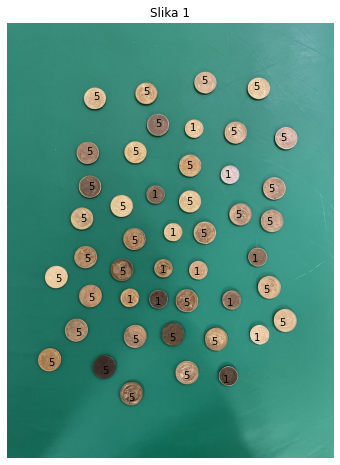

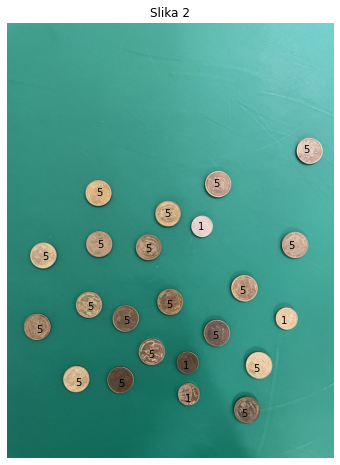

In [84]:
coef1 = 0.98
coef2 = 1.02

#plot text on top of image
plt.figure(figsize=(16,8))
for i in range(len(coin_centers1[0])):
    plt.text(coin_centers1[0][i][1]*coef1, coin_centers1[0][i][0]*coef2, '1', color='black', fontsize=10)
for i in range(len(coin_centers1[1])):
    plt.text(coin_centers1[1][i][1]*coef1, coin_centers1[1][i][0]*coef2, '5', color='black', fontsize=10)
plt.imshow(coin_image1, 'gray')
plt.title('Slika 1')
plt.axis('off');
plt.savefig('slike/coins1.png')     # čuvanje slike
plt.show()

plt.figure(figsize=(16,8))
for i in range(len(coin_centers2[0])):
    plt.text(coin_centers2[0][i][1]*coef1, coin_centers2[0][i][0]*coef2, '1', color='black', fontsize=10)
for i in range(len(coin_centers2[1])):
    plt.text(coin_centers2[1][i][1]*coef1, coin_centers2[1][i][0]*coef2, '5', color='black', fontsize=10)
plt.imshow(coin_image2, 'gray')
plt.title('Slika 2')
plt.axis('off');
plt.savefig('slike/coins2.png')     # čuvanje slike
plt.show()

Posmatranjem tabele i labeliranih slika, zaključuje se da među datim primerima slika, nigde ne dolazi do greške.

# Drugi zadatak

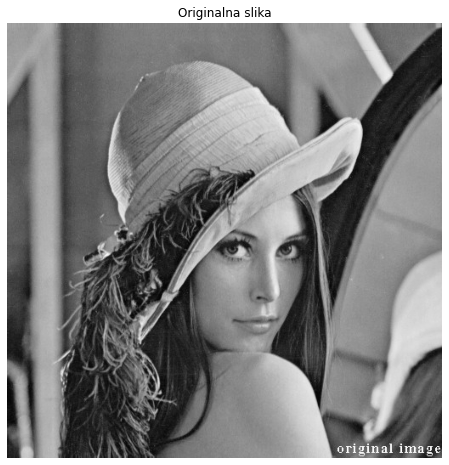

In [5]:
# ucitavanje slike
image2 = io.imread('../sekvence/lena.tif')
# prikaz slike
plt.figure(figsize=(16,8))
plt.imshow(image2, 'gray') 
plt.title('Originalna slika')
plt.axis('off');

### 1. Filtriranje Gausovom funkcijom

Zbog šuma koji se može javiti na slici (i potencijalno narušiti detektovanje samo bitnih ivica), prvo je potrebno primeniti filtriranje.

In [6]:
def gauss(image_in, std):
    """Određivanje veličine prozora"""
    n = int(np.ceil(6*std)) # prvi broj veci ili jednak 6*std
    if n%2 == 0:            # ako je paran 
        n += 1              # dodajemo 1

    """Formiranje prozora za filtriranje"""
    mask = np.zeros((n,n))

    # popunjavanje maske
    for i in range(n):
        for j in range(n):
            mask[i,j] = np.exp(-((i-n//2)**2 + (j-n//2)**2)/(2*std**2))

    # normalizacija
    mask = mask/np.sum(mask)

    """Filtriranje"""
    # gausovsko filtriranje primenom konvolucije
    gauss_image = cv2.filter2D(image_in, -1, mask)

    return gauss_image

In [7]:
image_gauss = gauss(image2, 2)  # primena gausovskog filtra

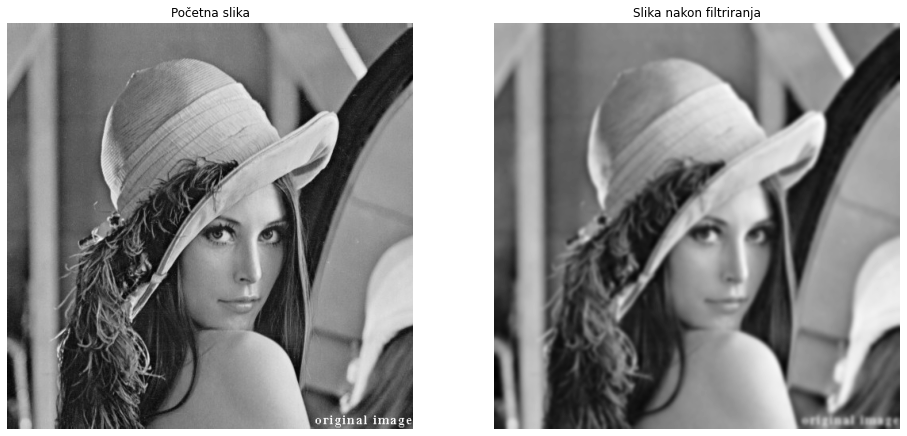

In [8]:
#prikaz slike nakon filtriranja 
plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.imshow(image2, 'gray')
plt.title('Početna slika')
plt.axis('off');
plt.subplot(1, 2, 2)
plt.imshow(image_gauss, 'gray')
plt.title('Slika nakon filtriranja')
plt.axis('off');

### 2. Određivanje horizontalnih i vertikalnih gradijenata filtrirane slike

Zatim je potrebno pronaći brzinu promene intenziteta piksela u horizontalnom i vertikalnom pravcu. Ovak korak karakterističan je za određivanje ivica iz razloga što baš kod njih dolazi do nagle promene intenziteta (izvod će biti veliki). Za ovaj korak koristili su se Sobel operatori.

In [9]:
def gradients(image_in):
    # sobel operatori
    hy = np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]])
    hx = np.array([[-1, -2, -1],
                    [0, 0, 0],
                    [1, 2, 1]])

    # konvolucija slike sa operatorima
    gradient_x = np.zeros(image_in.shape)
    gradient_y = np.zeros(image_in.shape)
    for i in range(1, image_in.shape[0]-1):
        for j in range(1, image_in.shape[1]-1):
            gradient_x[i,j] = np.sum(np.multiply(hx, image_in[i-1:i+2, j-1:j+2]))
            gradient_y[i,j] = np.sum(np.multiply(hy, image_in[i-1:i+2, j-1:j+2]))
    
    return gradient_x, gradient_y

In [10]:
grad_x, grad_y = gradients(image_gauss)

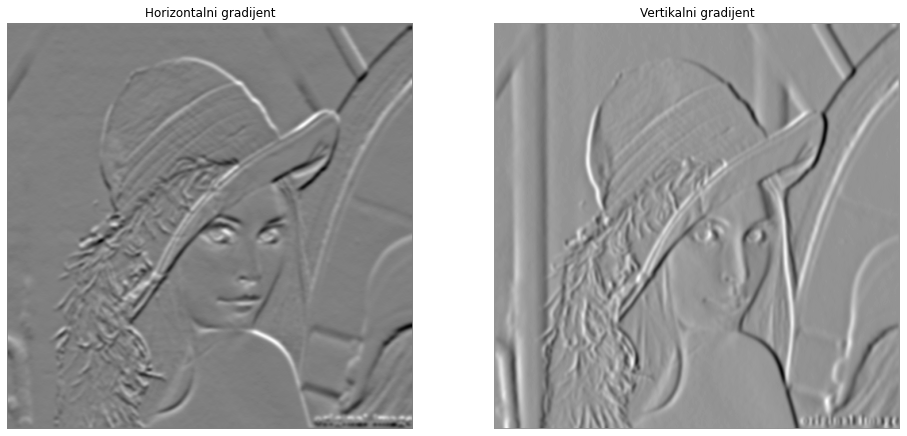

In [11]:
plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.imshow(grad_x, 'gray')
plt.title('Horizontalni gradijent')
plt.axis('off');
plt.subplot(1, 2, 2)
plt.imshow(grad_y, 'gray')
plt.title('Vertikalni gradijent')
plt.axis('off');

### 3. Određivanje magnitude i ugla gradijenta

Kombinacijom horizontalnih i vertikalnih gradijenata moguće je dobiti ukupni gradijent u svakom pikselu - magnitudu, kao i njeno prostiranje - ugao.

In [12]:
def mag_thet(gradient_x, gradient_y):
    magnitude = np.sqrt(gradient_x**2 + gradient_y**2)  # odredjivanje magnitude
    theta = np.arctan2(gradient_x, gradient_y)          # odredjivanje ugla

    return magnitude, theta

In [13]:
magnitude, theta = mag_thet(grad_y, grad_x)

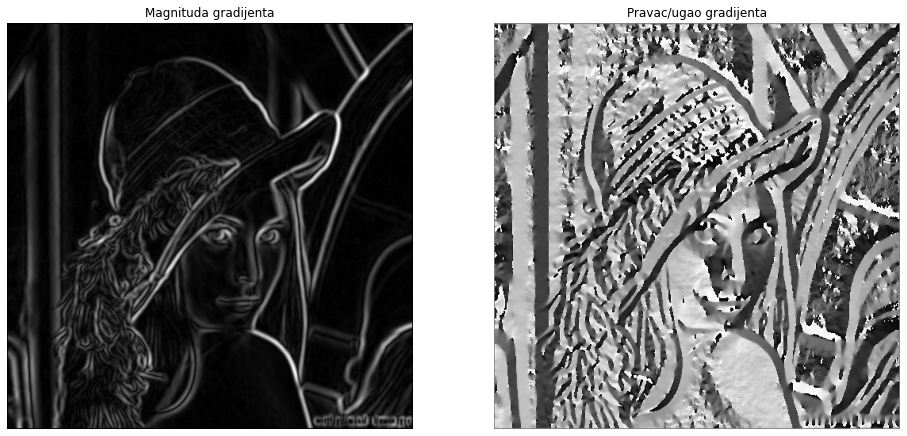

In [14]:
plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.imshow(magnitude, 'gray')
plt.title('Magnituda gradijenta')
plt.axis('off');
plt.subplot(1, 2, 2)
plt.imshow(theta, 'gray')
plt.title('Pravac/ugao gradijenta')
plt.axis('off');

In [15]:
max(set(theta.flatten())), min(set(theta.flatten()))

(3.141592653589793, -3.133045853157182)

### 4. Kvantizacija gradijenta na jedan od 4 pravaca (-45°, 0°, 45° i 90°)

Radi smanjenja broja mogućih pravaca prostiranja gradijenta, primenjuje se kvantizacija. Ovaj korak koristan je za ubrzavanje programa, smanjenje dimenzionalnosti, kao i otprnosti na male fluktuacije u vrednostima ugla gradijenta (šum).

In [16]:
def kvant(theta):
    for i in range(theta.shape[0]):
        for j in range(theta.shape[1]):
            # ako je ugao u opsegu od -22.5 do 22.5 ili od 157.5 do 180, postavi ga na 0
            if (theta[i,j] < 22.5*np.pi/180 and theta[i,j] > -22.5*np.pi/180) or (theta[i,j] > 157.5*np.pi/180) or (theta[i,j] < -157.5*np.pi/180):
                theta[i,j] = 0
            # ako je ugao u opsegu od 22.5 do 67.5 ili od -112.5 do -157.5, postavi ga na 45
            elif (theta[i,j] > 22.5*np.pi/180 and theta[i,j] < 67.5*np.pi/180) or (theta[i,j] < -112.5*np.pi/180 and theta[i,j] > -157.5*np.pi/180):
                theta[i,j] = np.pi/4
            # ako je ugao u opsegu od 67.5 do 112.5 ili od -67.5 do -112.5, postavi ga na 90
            elif (theta[i,j] > 67.5*np.pi/180 and theta[i,j] < 112.5*np.pi/180) or (theta[i,j] < -67.5*np.pi/180 and theta[i,j] > -112.5*np.pi/180):
                theta[i,j] = np.pi/2
            # ako je ugao u opsegu od 112.5 do 157.5 ili od -22.5 do -67.5, postavi ga na -45
            elif (theta[i,j] > 112.5*np.pi/180 and theta[i,j] < 157.5*np.pi/180) or (theta[i,j] < -22.5*np.pi/180 and theta[i,j] > -67.5*np.pi/180):
                theta[i,j] = -np.pi/4
                
    return theta

In [17]:
theta = kvant(theta)

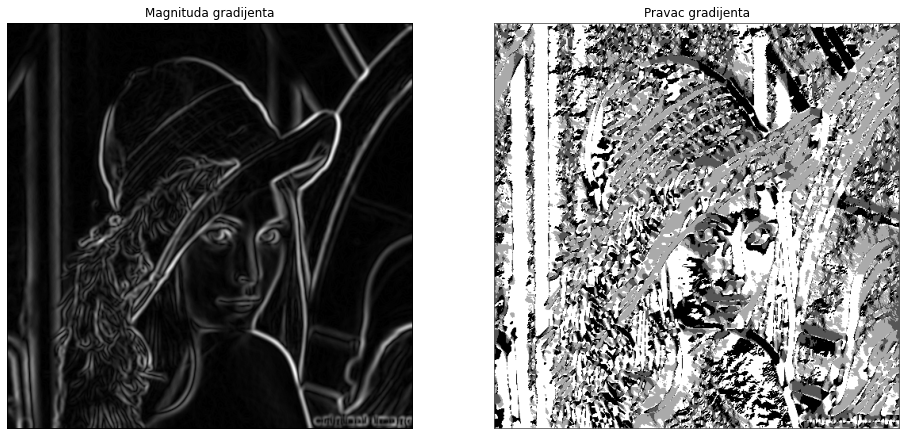

In [18]:
plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.imshow(magnitude, 'gray')
plt.title('Magnituda gradijenta')
plt.axis('off');
plt.subplot(1, 2, 2)
plt.imshow(theta, 'gray')
plt.title('Pravac gradijenta')
plt.axis('off');

### 5. Potiskivanje vrednosti gradijenta koje ne predstavljaju lokalne maksimume

Potiskivanje lokalnih ne-maksimuma služi da bi se debljina detektovane ivice smanjila na 1.

In [19]:
def potiskivanje(magnitude, angle):
    magnitude1 = np.copy(magnitude)
    for i in range(1,magnitude.shape[0]-1):
        for j in range(1,magnitude.shape[1]-1):
            if angle[i,j] == 0:
                # ako je trenutni piksel veći od susednih u pravcu gradijenta, ostavi ga, inače postavi na 0
                if not(magnitude[i,j] > magnitude[i-1,j] and magnitude[i,j] > magnitude[i+1,j]):
                    magnitude1[i,j] = 0
            if angle[i,j] == np.pi/4:
                # ako je trenutni piksel veći od susednih u pravcu gradijenta, ostavi ga, inače postavi na 0
                if not(magnitude[i,j] > magnitude[i-1,j-1] and magnitude[i,j] > magnitude[i+1,j+1]):
                    magnitude1[i,j] = 0
            if angle[i,j] == np.pi/2:
                # ako je trenutni piksel veći od susednih u pravcu gradijenta, ostavi ga, inače postavi na 0
                if not(magnitude[i,j] > magnitude[i,j-1] and magnitude[i,j] > magnitude[i,j+1]):
                    magnitude1[i,j] = 0
            if angle[i,j] == -np.pi/4:
                # ako je trenutni piksel veći od susednih u pravcu gradijenta, ostavi ga, inače postavi na 0
                if not(magnitude[i,j] > magnitude[i-1,j+1] and magnitude[i,j] > magnitude[i+1,j-+1]):
                    magnitude1[i,j] = 0

    return magnitude1

In [20]:
magnitude = potiskivanje(magnitude, theta)

In [21]:
magnitude = magnitude/np.max(magnitude)    # normalizacija

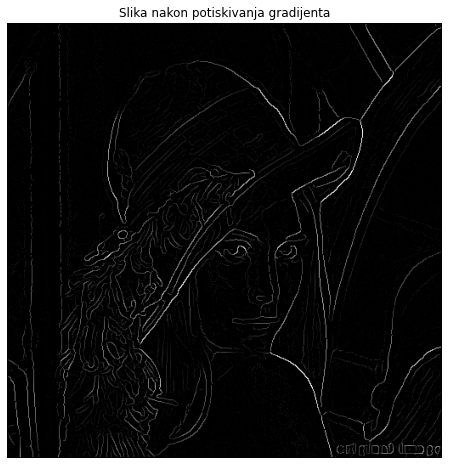

In [22]:
plt.figure(figsize=(16,8))
plt.imshow(magnitude, 'gray')
plt.title('Slika nakon potiskivanja gradijenta')
plt.axis('off');

### 6. Određivanje mapa jakih i slabih ivica

Pomoću gornjeg i donjeg praga određuju se jake (sve koje imaju vrednost preko gornjeg praga) i slabe (one koje imaju vrednost između donjeg i gornjeg praga) ivice.

In [23]:
def slabe_jake_ivice(magnitude, up, down):
    # inicijalizacija granica
    strong_edges = np.zeros(magnitude.shape)
    weak_edges = np.zeros(magnitude.shape)
    for i in range(magnitude.shape[0]):
        for j in range(magnitude.shape[1]):
            if magnitude[i,j] > up:     # ako je piksel jači od gornje granice, postavi ga u strong_edges
                strong_edges[i,j] = 1
            elif magnitude[i,j] > down: # ako je piksel jači od donje granice, postavi ga u weak_edges
                weak_edges[i,j] = 1

    return strong_edges, weak_edges

In [24]:
strong_edges, weak_edges = slabe_jake_ivice(magnitude, 0.22, 0.1)

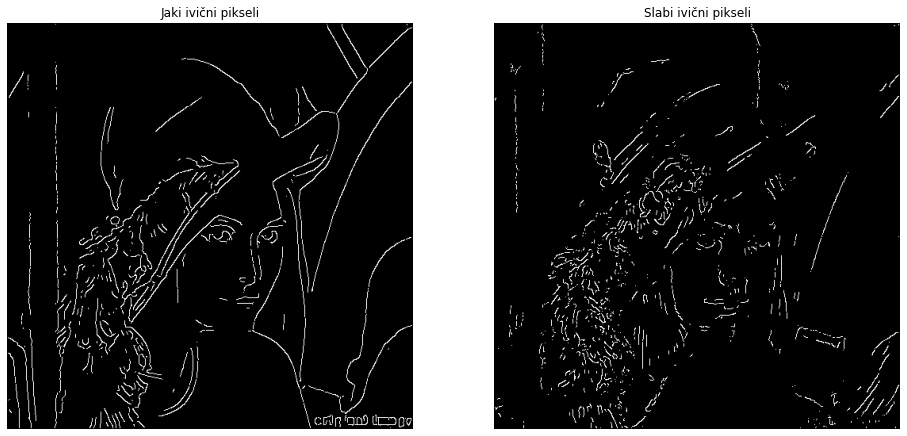

In [25]:
#prikaz jakih i slabih ivica na pocetku
plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.imshow(strong_edges, 'gray')
plt.title('Jaki ivični pikseli')
plt.axis('off');
plt.subplot(1, 2, 2)
plt.imshow(weak_edges, 'gray')
plt.title('Slabi ivični pikseli')
plt.axis('off');

### 7. Uključivanje slabijih ivica

Dobijene mape potrebno je iskoristiti za dobijenje finalne mape ivica. Postupak koji se prati prebacuje slabe poksele (koji pripadaju ivicama) u jake u slučaju kada se slabi piksel dodiruje sa bar jednim jakim. Konvergencija se dostiže kada se u dva uzastopna koraka ne promeni finalna maska.

In [26]:
def ukljucivanje(strong_edges, weak_edges):
    # ako je neka slaba ivica povezana sa jakom ukljuciti je 
    while True:
        weak_edges1 = weak_edges.copy()
        for i in range(1, strong_edges.shape[0]-1):
            for j in range(1, strong_edges.shape[1]-1):
                if weak_edges[i,j] != 0:    # ako je trenutni piksel slab ivični piksel
                    # ako je neki od susednih piksela jak ivični piksel, uključiti trenutni piksel
                    if strong_edges[i-1,j-1] != 0 or strong_edges[i-1,j] != 0 or strong_edges[i-1,j+1] != 0 or strong_edges[i,j-1] != 0 or strong_edges[i,j+1] != 0 or strong_edges[i+1,j-1] != 0 or strong_edges[i+1,j] != 0 or strong_edges[i+1,j+1] != 0:
                        strong_edges[i,j] = weak_edges1[i,j]
                        weak_edges1[i,j] = 0
        if sum(sum(weak_edges1 == weak_edges)) == weak_edges.shape[0]*weak_edges.shape[1]:  # ako se nista nije promenilo, prekini petlju
            break
        else:
            weak_edges = weak_edges1.copy()
    
    return strong_edges, weak_edges

In [27]:
strong_edges, weak_edges = ukljucivanje(strong_edges, weak_edges)

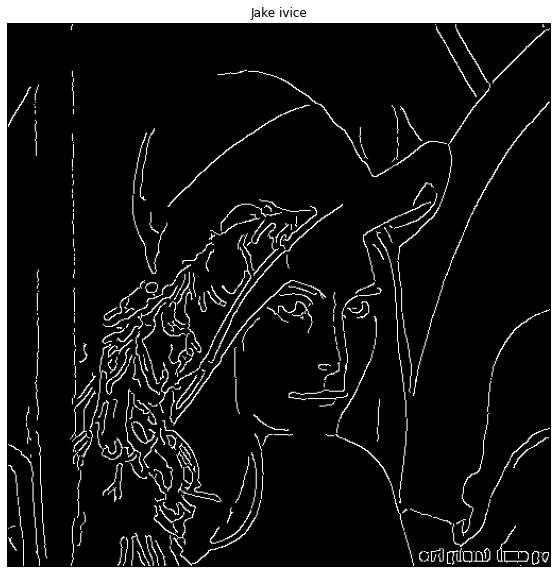

In [28]:
# prikaz konacne slike
plt.figure(figsize=(15,10))
plt.imshow(strong_edges, 'gray')
plt.title('Jake ivice')
plt.axis('off');

### Formiranje funkcije od prethodnih koraka i analiza parametara

In [29]:
def canny_edge_detection(image_in, std, down_thresh, up_thresh):

    gauss_image = gauss(image_in, std)                    # primena gausovskog filtra

    gradient_x, gradient_y = gradients(gauss_image)       # odredjivanje gradijenata

    magnitude, theta = mag_thet(gradient_y, gradient_x)  # odredjivanje magnitude i ugla

    theta = kvant(theta)                                   # kvantizacija ugla
        
    magnitude = potiskivanje(magnitude, theta)            # potiskivanje ivica 
    magnitude = magnitude/np.max(magnitude)               # normalizacija

    strong_edges, weak_edges = slabe_jake_ivice(magnitude, up_thresh, down_thresh)  # odredjivanje jakih i slabih ivica
    strong_edges, weak_edges = ukljucivanje(strong_edges, weak_edges)                # uključivanje slabih ivica

    return strong_edges

U narednom koraku formirana funkcija primenjena je na slici "lena", za različite vrednosti standardne devijacije.

In [30]:
slika = io.imread('../sekvence/lena.tif')

In [506]:
stds = [0.001, 0.5, 1, 2, 5, 8] # standardne devijacije
image_out1 = canny_edge_detection(slika, stds[0], 0.1, 0.22)
image_out2 = canny_edge_detection(slika, stds[1], 0.1, 0.22)
image_out3 = canny_edge_detection(slika, stds[2], 0.1, 0.22)
image_out4 = canny_edge_detection(slika, stds[3], 0.1, 0.22)
image_out5 = canny_edge_detection(slika, stds[4], 0.1, 0.22)
image_out6 = canny_edge_detection(slika, stds[5], 0.1, 0.22)

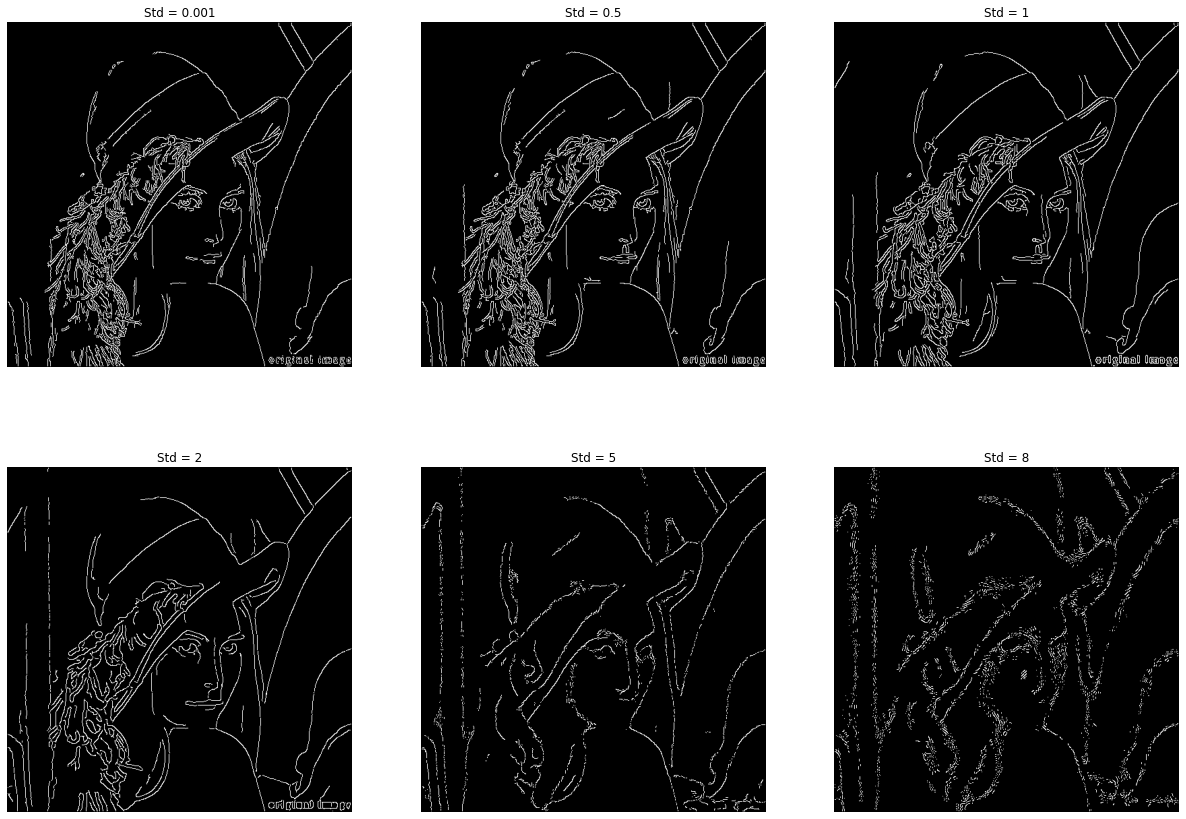

In [507]:
plt.figure(figsize=(21,15))
for i in range(1,7):
    plt.subplot(2, 3, i)
    plt.imshow(eval('image_out'+str(i)), 'gray')
    plt.title('Std = '+str(stds[i-1]))
    plt.axis('off');

Povećanje standardne devijacije dovodi do većeg zamućenja slike, a to se ogleda u detektovanju samo najevidentnijih kontura i nemogućnosti detektovanja manjih prelaza i ivica sa početne slike.     
Za najbolje dobijene rezultate uzeta je standardna devijacija od 2.

Sada se za fiksnu std variraju parametri gornje granice (donja granica je identična) za određivanje jakih ivica.

In [508]:
up_threshs = [0.5, 0.4, 0.3, 0.2, 0.1, 0.05]    # gornje granice
image_out7 = canny_edge_detection(slika, 2, up_threshs[0], up_threshs[0])
image_out8 = canny_edge_detection(slika, 2, up_threshs[1], up_threshs[1])
image_out9 = canny_edge_detection(slika, 2, up_threshs[2], up_threshs[2])
image_out10 = canny_edge_detection(slika, 2, up_threshs[3], up_threshs[3])
image_out11 = canny_edge_detection(slika, 2, up_threshs[4], up_threshs[4])
image_out12 = canny_edge_detection(slika, 2, up_threshs[5], up_threshs[5])

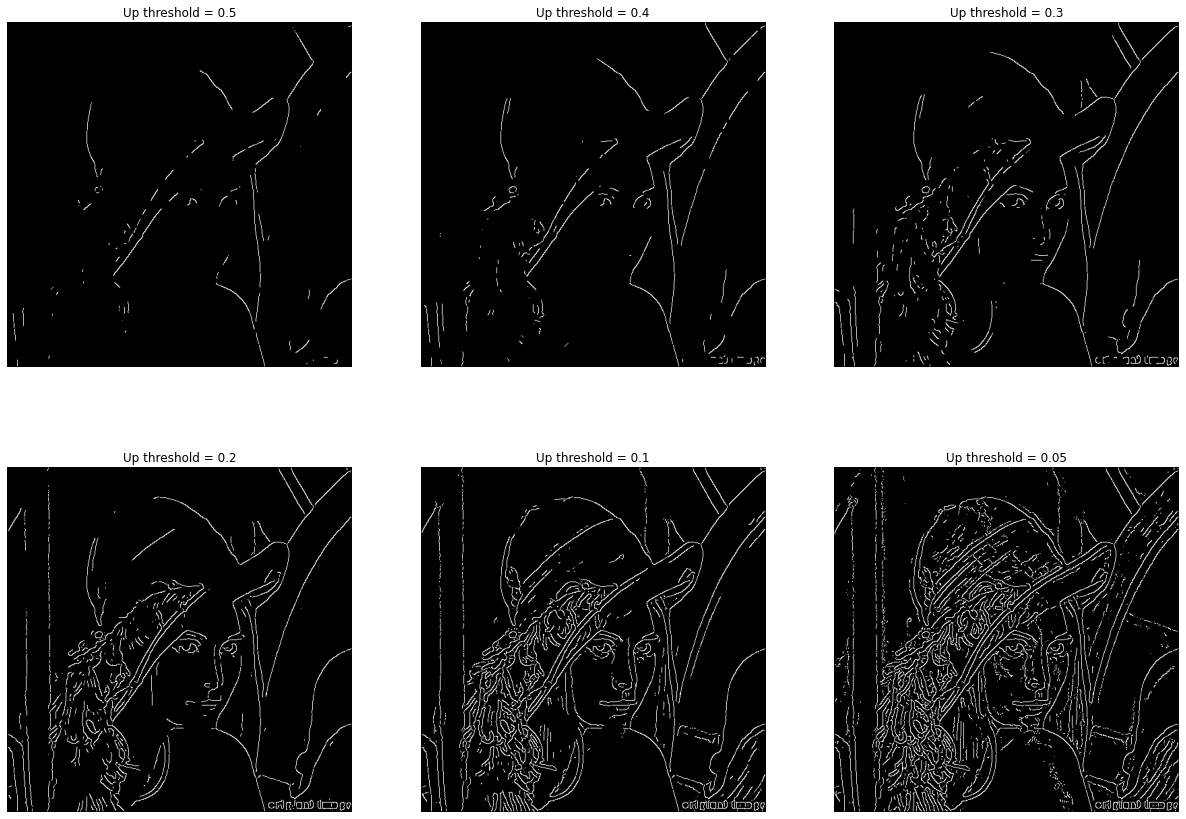

In [509]:
plt.figure(figsize=(21,15))
for i in range(1,7):
    plt.subplot(2, 3, i)
    plt.imshow(eval('image_out'+str(6+i)), 'gray')
    plt.title('Up threshold = '+str(up_threshs[i-1]))
    plt.axis('off');

Analizom gornjeg praga koji definiše jake ivice zaključuje se da vrenost 0.2 daje optimalnu količinu izdvojenih ivica. Pragovi preko ne detektuju dovoljno ivica, dok niže vrednosti nekada mogu zahvatiti dosta šuma.

Sada se za fiksnu std i gornju granicu variraju parametri donje granice za određivanje slabih ivica.

In [33]:
down_threshs = [0, 0.05, 0.1, 0.125, 0.15, 0.175]    # donje granice
image_out13 = canny_edge_detection(slika, 2, down_threshs[0], 0.2)
image_out14 = canny_edge_detection(slika, 2, down_threshs[1], 0.2)
image_out15 = canny_edge_detection(slika, 2, down_threshs[2], 0.2)
image_out16 = canny_edge_detection(slika, 2, down_threshs[3], 0.2)
image_out17 = canny_edge_detection(slika, 2, down_threshs[4], 0.2)
image_out18 = canny_edge_detection(slika, 2, down_threshs[5], 0.2)

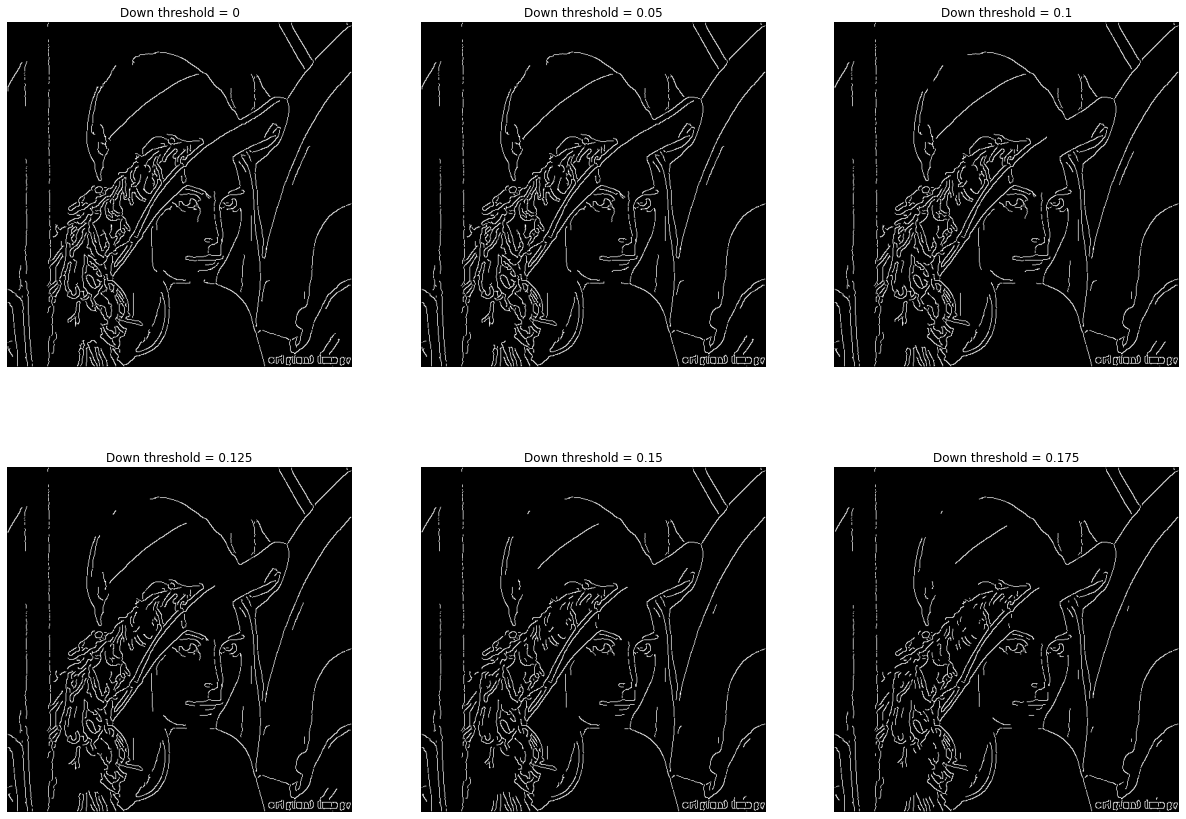

In [511]:
plt.figure(figsize=(21,15))
for i in range(1,7):
    plt.subplot(2, 3, i)
    plt.imshow(eval('image_out'+str(12+i)), 'gray')
    plt.title('Down threshold = '+str(down_threshs[i-1]))
    plt.axis('off');

Analizom promene parametara donje granice, ne uočavaju se preterane razlike. Njenim povećanjem se svakako pojavljuju dodatni delovi ivica (uočljivije na drugim primerima). Za optimalnu vrednost se uzima 0.125.

Poređenje ivica dobijenih primenom implementirane i ugrađene metode:

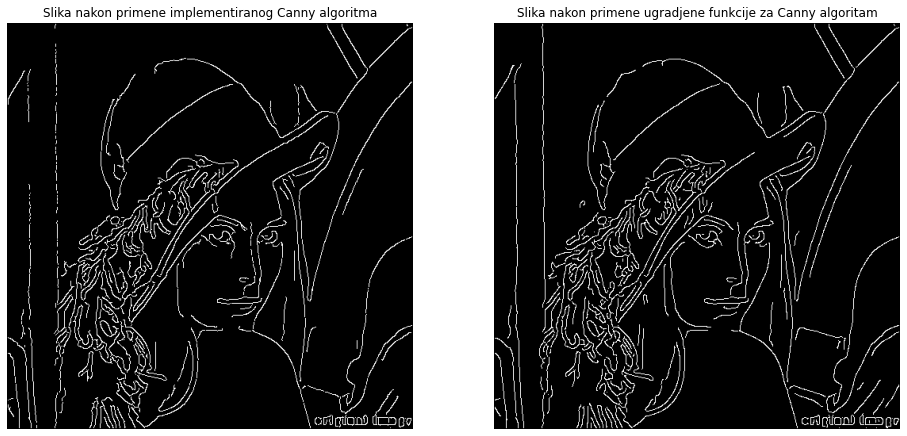

In [34]:
plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.imshow(image_out13, 'gray')
plt.title('Slika nakon primene implementiranog Canny algoritma')
plt.axis('off');
plt.subplot(1, 2, 2)
plt.imshow(feature.canny(slika, sigma=2), 'gray')
plt.title('Slika nakon primene ugradjene funkcije za Canny algoritam')
plt.axis('off');

Ukoliko se uporede performanse implementirane i ugrađene funkcije za Canny filtar, ne primećuju se značajne razlike. Neki delovi slike su malo šturiji i to se može rešiti blagim povećavanjem višeg praga.

### Isprobavanje funkcije na drugim slikama

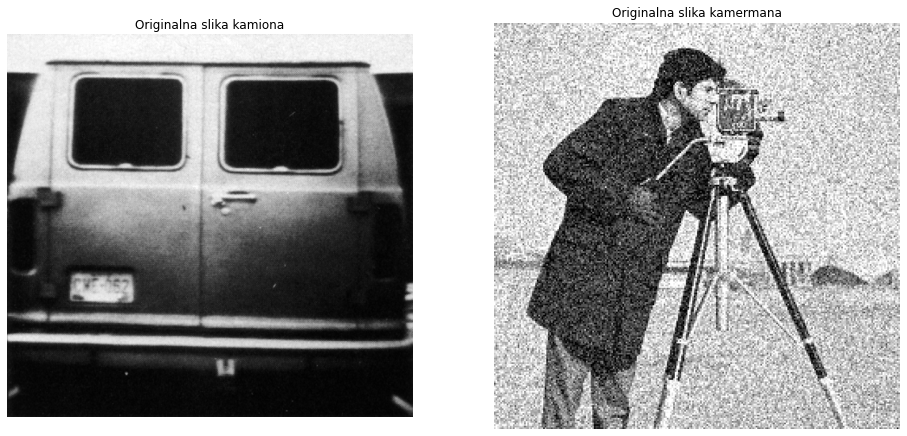

In [37]:
# ucitavanje slika
image_van = io.imread('../sekvence/van.tif')
image_camerman = io.imread('../sekvence/camerman.tif')

# prikaz slika
plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.imshow(image_van, 'gray')
plt.title('Originalna slika kamiona')
plt.axis('off');
plt.subplot(1, 2, 2)
plt.imshow(image_camerman, 'gray')
plt.title('Originalna slika kamermana')
plt.axis('off');

In [38]:
van_canny = canny_edge_detection(image_van, 2, 0, 0.2) # primena Canny algoritma na sliku kamiona

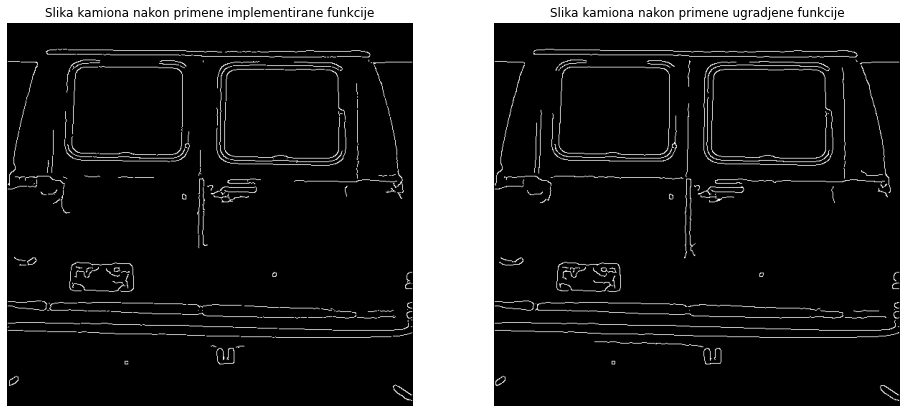

In [39]:
plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.imshow(van_canny, 'gray')
plt.title('Slika kamiona nakon primene implementirane funkcije')
plt.axis('off');
plt.subplot(1, 2, 2)
plt.imshow(feature.canny(image_van, sigma=2), 'gray')
plt.title('Slika kamiona nakon primene ugradjene funkcije')
plt.axis('off');

In [40]:
camerman_canny = canny_edge_detection(image_camerman, 2, 0.1, 0.17)    # primena Canny algoritma na sliku kamermana

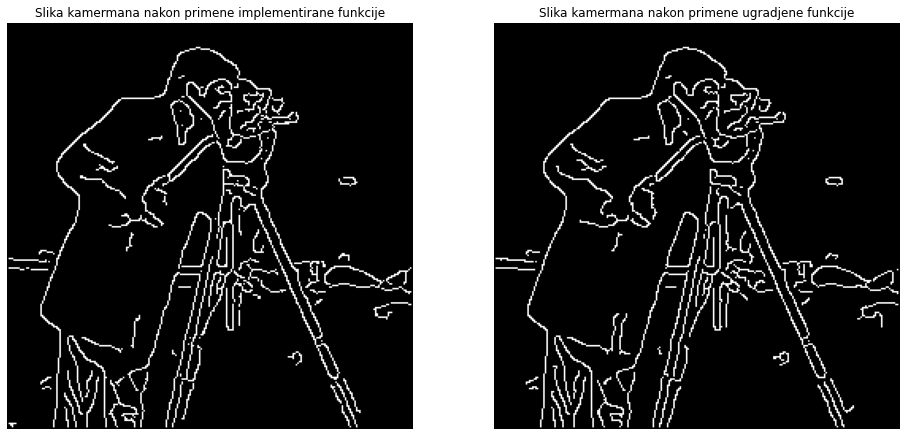

In [41]:
plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.imshow(camerman_canny, 'gray')
plt.title('Slika kamermana nakon primene implementirane funkcije')
plt.axis('off');
plt.subplot(1, 2, 2)
plt.imshow(feature.canny(image_camerman, sigma=2), 'gray')
plt.title('Slika kamermana nakon primene ugradjene funkcije')
plt.axis('off');

Analizom promene parametara za obe slike, konačno su izabrani:      
van - std: 2, donji prag: 0, gornji prag: 0.2        
camerman - std: 2, donji prag: 0.1, gornji prag: 0.17     

Na slici sa kamermanom, detektovane su veoma slične ivice. Pomoću implementirane funkcije na par mesta se nazire malo šuma, kao i nedostatak linija kod ruke.        
Na slici sa kombijem, primećuje se da se u središnjem svetlom delu gubi linija koja je ugrađenom funkcijom detektovana. Ovaj problem se može rešiti korišćenjem manje standardne devijacije.